In [1]:
''' Bibliotecas que serão utilizadas para a análise e limpeza dos dados '''
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:

## Loading our data from the data folders

orders = pd.read_csv('../data/raw/orders.csv')
products = pd.read_csv('../data/raw/product.csv')
client_ch = pd.read_csv('../data/raw/client.challenge.csv')
client_tr = pd.read_csv('../data/raw/client.train.csv')
client_te = pd.read_csv('../data/raw/client.test.csv')

# Info
📋 Tabelas - orders, products

🔑 Chaves em comum -  product_id

🎯 Variável target/interesse - is_churn inside client_tr & client_te

### Pequeno estudo de Correlação (Só pra aprender rapidin eu prometo)

Uma das ferramentas mais importantes na análise de dados é a Correlação

![Correlação](imgs/correlation.png)

Analisando como as variáveis estão distribuídas dentro de um plano cartesianos quando "batidas" umas com as outras nos mostra o quanto a presença de uma variável explica outra variável

Saber o coeficiente de correlação linear pode nos ajudar a prever valores futuros

[COEFICIENTE DE CORRELAÇÃO LINEAR - MATEMATICA RAPIDOLA](https://www.youtube.com/watch?v=ayAxTRN4aVg)

<AxesSubplot:>

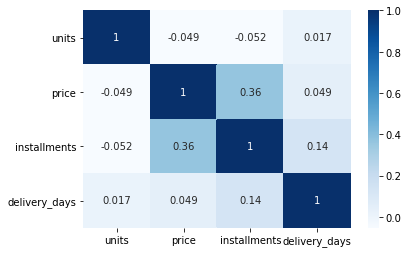

In [3]:
sns.heatmap(orders.corr(),cmap="Blues", annot=True)

<AxesSubplot:xlabel='price', ylabel='installments'>

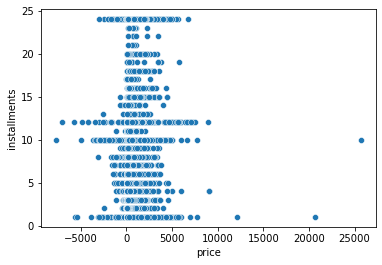

In [33]:
sns.scatterplot(data=orders,
                x="price",
                y="installments")

<AxesSubplot:xlabel='price', ylabel='units'>

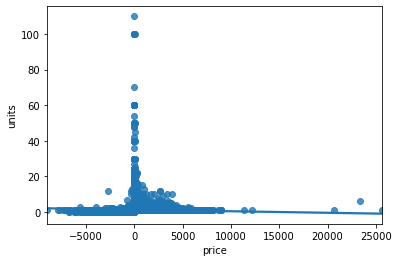

In [34]:
sns.regplot(data=orders,
                x="price",
                y="units")

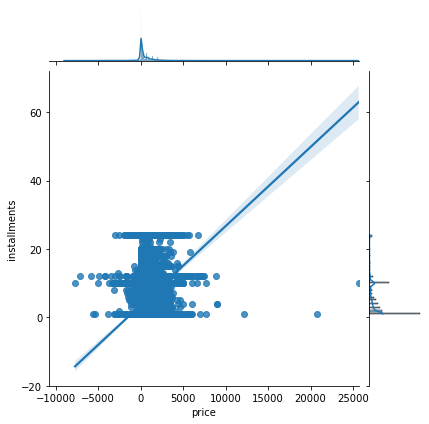

In [35]:
sns.jointplot(data=orders,
              x="price",
              y="installments",
              kind="reg")

# Missing Values

Here, we will use the power of Missingno to find missing information inside our data
This will help us understand our dataset and begin the Data Cleaning process

In [4]:
#!pip install missingno
import missingno as msno

Index(['order_id', 'client_id', 'product_id', 'datetime', 'units', 'price',
       'payment_method', 'installments', 'delivery_days', 'delivery_state',
       'device', 'source'],
      dtype='object')


<AxesSubplot:>

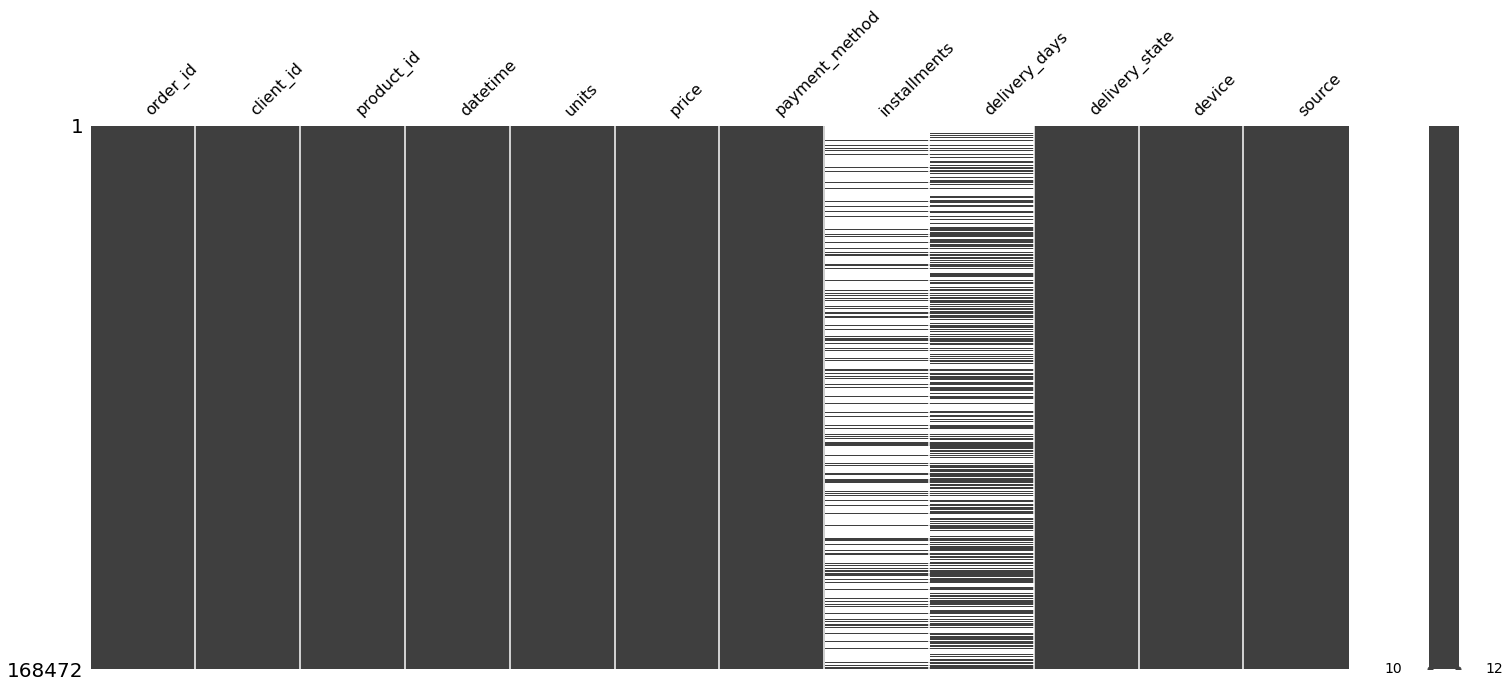

In [37]:
print(orders.keys())
msno.matrix(orders)

### Transformando valores nulos

Com base em nosso conhecimento do banco de dados, e algumas suposições que podemos criar agora na análise, iremos fazer transformações nos dados para que estes valores nulos possam ser contabilizados em nossa análise

Por exemplo:

 - Installments : Aqui podemos ver que há muitos valores nulos na tabela installments. Como veremos a seguir, esses valores nulos não parecem ter nada de errado, nada de diferente de outros registros que têm parcelamento registrado. Iremos criar esta REGRA, de que todo valor não registrado em parcelamento significa que o cliente pagou imediatamente, ou com bonus dentro do site
 - Delivery_days : Muitos produtos podem ser entregues instantaneamente. Como é o caso de e-books, cursos online, etc. Iremos considerar também que a entrega é imediata
  
E o que eu quero dizer?
Bom, a maioria das variáveis dentro de ambas essas colunas são discretas

O único valor que não temos explicação são os valores nulos, que parecem indicar que eles valeriam 0 como variáveis discretas

![nulos](imgs/nulos.png)

### Novas variáveis

Então criaremos algumas variáveis novas, para que possamos analisar nossa hipótese e também tirar novas conclusões

São elas:
- has_installments : Variável discreta Binária (1/0)[True/False] criada em função da coluna Installments
- installments(update) : Com a mesma lógica de has_installments, se não há registro = 0 (pagto instantâneo)
- has_delivery_days : Variável discreta Binária (1/0)[True/False] criada em função da coluna delivery_days

In [3]:
# Transformação dos dados

orders['has_installments'] = np.where(orders["installments"].isna() == False, 1, 0)

orders['installments'] = np.where(orders["installments"].isna() == True, 0, orders['installments'])

orders['has_delivery_days'] = np.where(orders["delivery_days"].isna() == False, 1, 0)

In [39]:
# visualização da transformação

orders[orders["installments"] == 0].head(1)

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,has_installments,has_delivery_days
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,0.0,NaN,st07,dv9,sc08,0,0


<AxesSubplot:>

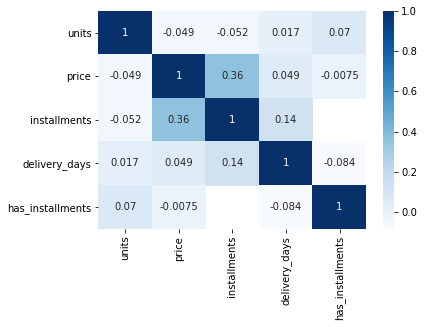

In [13]:
sns.heatmap(orders.corr(), cmap="Blues", annot=True)

KeyboardInterrupt: 

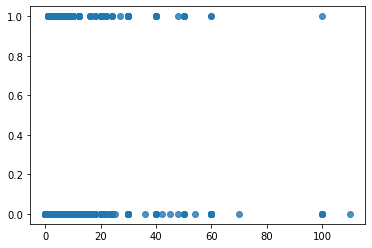

In [14]:
sns.regplot(data=orders,
            x="units",
            y="has_installments",
            logistic=True)

<AxesSubplot:xlabel='units', ylabel='installments'>

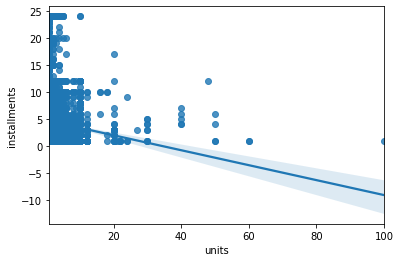

In [3]:
sns.regplot(data=orders,
            x="units",
            y="installments")

<AxesSubplot:xlabel='units', ylabel='installments'>

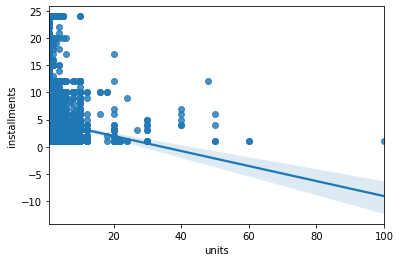

In [4]:
sns.regplot(data=orders,
            x="units",
            y="installments")

In [ ]:
sns.regplot(data=orders,
            x="units",
            y="has_delivery_days",
            logistic=True)

## E-books, entregas imediatas, entre outros

Esta correlação entre as variáveis units e has_delivery_days parece indicar que, quando a compra é de mais de uma unidade, ela quase certamente terá uma entrega, ou data de entrega preenchida

Ou o contrário. Se ela tem data de entrega, provavelmente é uma compra de mais de uma unidade

In [ ]:
sns.regplot(data=orders,
            x="price",
            y="has_delivery_days",
            logistic=True)

Se observarmos bem, essa correlação é quase neutra quando o preço chega a 0

![regressao_logistica](imgs/logistic_01.png)

Essa correlação parece nos indicar que, sempre que o registro dentro do banco de dados é de um produto com custo acima de 0, haverá um entrega de um produto

Na minha opinião, isso parece indicar que todo registro com preço negativo é de um desconto aplicado sobre uma ordem anterior ou uma devolução referente a produto quebrado/defeituoso

In [ ]:
sns.regplot(data=orders,
            x="installments",
            y="has_delivery_days",
            logistic=True)

<AxesSubplot:xlabel='installments', ylabel='has_delivery_days'>

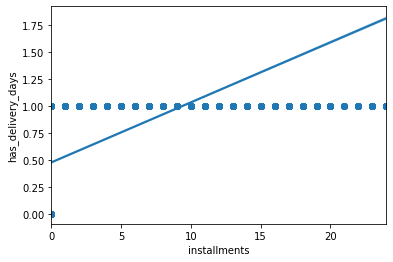

In [19]:
sns.regplot(data=orders,
            x="installments",
            y="has_delivery_days")

In [ ]:
sns.regplot(data=orders,
            x="price",
            y="has_delivery_days",
            logistic=True)

Esses dois gráficos parecem nos indicar que, quando há uma data de entrega, certamente haverá um parcelamento, qualquer que seja o valor desse parcelamento

O contrário também pode ser verdadeiro: Quando há um parcelamento, certamento haverá uma entrega



# Merging data

In [ ]:
customer_orders = orders.merge(client_ch,how='right', on="client_id")

In [ ]:
sns.regplot(data=customer_orders,
            x="price",
            y="has_delivery_days",
            logistic=True)

In [ ]:
customer_orders.head()

In [ ]:
customer_orders.to_csv("../data/processed/customer_orders.csv")

# Mais Feature Engine

Nova Variável:
- has_discount: Variável binária (1/0) em função da coluna price

In [ ]:
customer_orders[customer_orders["price"] < 0].head()

In [ ]:
customer_orders['has_discount'] = np.where(customer_orders["price"] < 0, 1, 0)
customer_orders.head()